In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dismech

np.concat = np.concatenate
np.bool = np.bool_

geom = dismech.GeomParams(rod_r0=0,
                          shell_h=1e-3)

material = dismech.Material(density=1200,
                            youngs_rod=0,
                            youngs_shell=2e11,  # stainless steel
                            poisson_rod=0,
                            poisson_shell=0.5)

static_3d_sim = dismech.SimParams(static_sim=True,
                                  two_d_sim=False,
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-2,
                                  max_iter=25,
                                  total_time=1e-2,
                                  plot_step=10,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
# env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))

# geo = dismech.Geometry.from_txt('four_corner.txt')
geo = dismech.Geometry.from_txt('mesh_python_example1.txt')

robot = dismech.SoftRobot(geom, material, geo, static_3d_sim, env)

In [2]:
# ### Energy

# set strain_bar
#  instance    = package.class        (instance.object(list type), instance.instance)
stretch_energy = dismech.StretchEnergy(robot.stretch_springs, robot.state)

# FIXME: Mid-edge breaks for this!!
if robot.sim_params.use_mid_edge:
    shell_energy = dismech.TriangleEnergy(robot.triangle_springs, robot.state)
else:
    shell_energy = dismech.HingeEnergy(robot.hinge_springs, robot.state)

# of thetas:  (50,)
[array([ 2.49999987e-09,  2.50000010e-09, -7.07106780e-05]), array([ 0.00411113,  0.00411113, -0.09049008]), array([ 0.01636422,  0.01636422, -0.17942369]), array([ 0.03655809,  0.03655809, -0.26541136]), array([ 0.06436118,  0.06436118, -0.34704126]), array([ 0.09931699,  0.09931699, -0.42297311]), array([ 0.14085159,  0.14085159, -0.4919602 ]), array([ 0.18828302,  0.18828302, -0.55286983]), array([ 0.24083251,  0.24083251, -0.60470193]), array([ 0.29763725,  0.29763725, -0.64660547]), array([ 0.35776458,  0.35776458, -0.67789245]), array([ 0.42022725,  0.42022725, -0.69804915]), array([ 0.48399971,  0.48399971, -0.70674464]), array([ 0.54803487,  0.54803487, -0.70383613]), array([ 0.61128136,  0.61128136, -0.68937139]), array([ 0.67270072,  0.67270072, -0.66358792]), array([ 0.73128452,  0.73128452, -0.62690903]), array([ 0.78607088,  0.78607088, -0.57993698]), array([ 0.83616027,  0.83616027, -0.52344298]), array([ 0.88073026,  0.88073026, -0.45835461]), array([

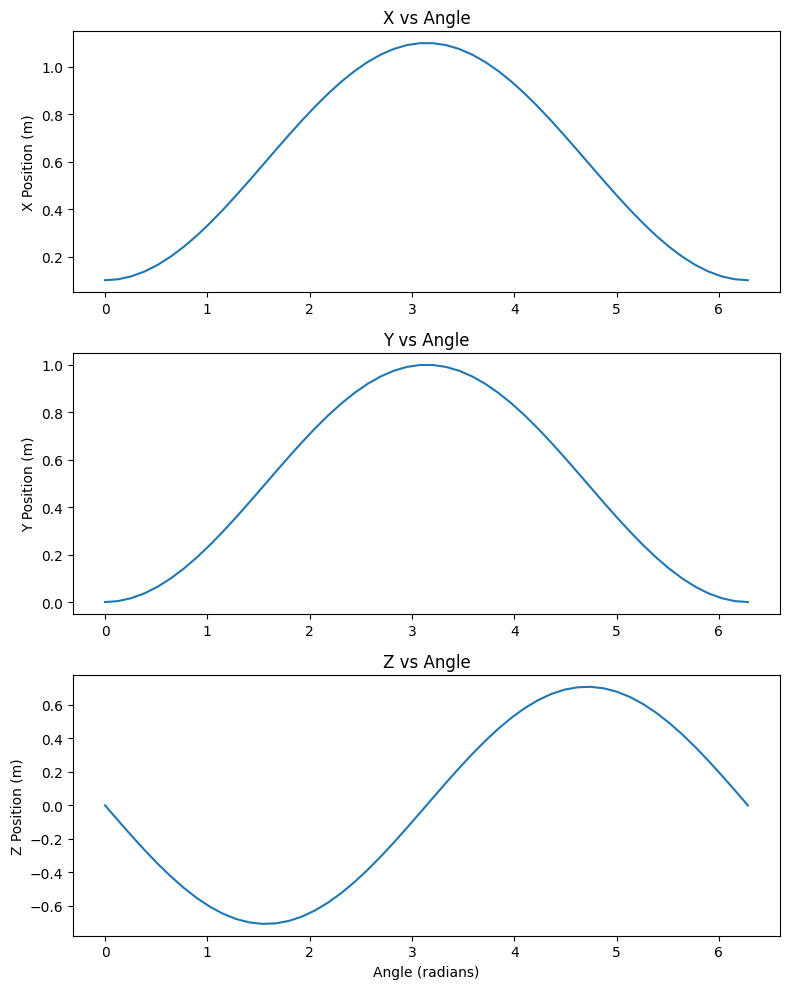

(50, 3)
(3,)


In [3]:
def get_node4_folded_position(theta):
    A = np.array([0, 1, 0])
    B = np.array([1, 0, 0])

    K = B - A
    K = K / np.linalg.norm(K)
    ref_vector = np.array([1, 1, 0]) - A
    M = np.cross(K, ref_vector)
    M = M / np.linalg.norm(M)
    N = np.cross(M, K)
    radius = np.linalg.norm(ref_vector - np.dot(ref_vector, K) * K)
    rotated_point = (
        A
        + np.dot(ref_vector, K) * K
        + radius * (np.cos(theta - np.pi) * N + np.sin(theta - np.pi) * M)
    )
    
    return np.array(rotated_point)

# Get displaced positions
thetas = np.linspace(0 + 1e-4, 2 * np.pi - 1e-4)
positions = [get_node4_folded_position(theta) for theta in thetas] 
print("# of thetas: ", thetas.shape)
print(positions)

positions_array = np.array(positions)  # Shape: (50, 3)

# Add stretch. 03-25
vector_to_add = np.array([0.1, 0.0, 0])
positions_array_new = positions_array + vector_to_add
positions_array=positions_array_new
positions_list = positions_array.tolist()
positions=positions_list


fig, axs = plt.subplots(3, 1, figsize=(8, 10))
axs[0].plot(thetas, positions_array[:, 0])
axs[0].set_title("X vs Angle")
axs[0].set_ylabel("X Position (m)")

axs[1].plot(thetas, positions_array[:, 1])
axs[1].set_title("Y vs Angle")
axs[1].set_ylabel("Y Position (m)")

axs[2].plot(thetas, positions_array[:, 2])
axs[2].set_title("Z vs Angle")
axs[2].set_ylabel("Z Position (m)")
axs[2].set_xlabel("Angle (radians)")

plt.tight_layout()
plt.show()


print(positions_array.shape)
print(vector_to_add.shape)

In [4]:
# Create a robot with all fixed nodes (w/o gravity)
base_robot = dismech.SoftRobot(geom, material, geo, static_3d_sim, dismech.Environment())
base_robot = base_robot.fix_nodes([0,1,2])

robots = []
he = []
se = []

# Helper functions for energy
data = []   # list of dictionaries of dictionaries

def get_node_to_edge_id(robot):
    def helper(edge):
        a, b = edge
        match = np.where((robot._SoftRobot__edges == [a, b]).all(
            axis=1) | (robot._SoftRobot__edges == [b, a]).all(axis=1))[0]
        return match[0] if match.size > 0 else None
    return helper

def get_entry(state, springs, energy, nodes_to_edge_id):
    ret = {}
    strain = energy.get_strain(state)
    energy_arr = energy.get_energy_linear_elastic(state, False)
    for i, spring in enumerate(springs):
        # Both hinge and stretch first 2 nodes are around main edge
        edge_id = nodes_to_edge_id(spring.nodes_ind[:2])
        ret[int(edge_id)] = (strain[i], energy_arr[i][0])
    return ret

n_to_e = get_node_to_edge_id(robot)

# For each position, displace the node and evaluate the hinge and stretching energy
for pos in positions:
    disp_robot = base_robot.move_nodes([3], pos - np.array([1,1,0]))
    robots.append(disp_robot)
    he.append(shell_energy.get_energy_linear_elastic(disp_robot.state))
    se.append(stretch_energy.get_energy_linear_elastic(disp_robot.state))

    # Create a temporary array and then append the separate elastic energies into data list
    temp = {}
    temp['Stretch'] = get_entry(disp_robot.state, robot.stretch_springs, stretch_energy, n_to_e)
    temp['Hinge'] = get_entry(disp_robot.state, robot.hinge_springs, shell_energy, n_to_e)
    data.append(temp)

qs = np.stack([robot.state.q for robot in robots])

In [5]:
print(len(he))
print(len(se))
print(len(data))
print( len (data[0].items()  ) )
print( data[0].items() )
print(n_to_e)

50
50
50
2
dict_items([('Stretch', {0: (np.float64(-1.1102230246251565e-16), np.float64(0.0)), 1: (np.float64(0.0), np.float64(0.0)), 2: (np.float64(0.0), np.float64(0.0)), 3: (np.float64(0.0), np.float64(0.0)), 4: (np.float64(0.0), np.float64(0.0)), 5: (np.float64(-1.1102230246251565e-16), np.float64(0.0)), 6: (np.float64(0.0), np.float64(0.0)), 7: (np.float64(0.0), np.float64(0.0)), 8: (np.float64(0.0), np.float64(0.0)), 9: (np.float64(-1.1102230246251565e-16), np.float64(0.0)), 10: (np.float64(0.0), np.float64(0.0)), 11: (np.float64(-1.1102230246251565e-16), np.float64(0.0)), 12: (np.float64(0.0), np.float64(0.0)), 13: (np.float64(11.806248459248321), np.float64(120713118.2922534)), 14: (np.float64(12.795618593645449), np.float64(141793610.70095223)), 15: (np.float64(0.0), np.float64(0.0)), 16: (np.float64(0.0), np.float64(0.0)), 17: (np.float64(0.0), np.float64(0.0)), 18: (np.float64(-1.1102230246251565e-16), np.float64(0.0)), 19: (np.float64(-1.1102230246251565e-16), np.float64(0.

In [6]:
import csv

def write_elastic_energy_csv(data, filename="elastic_energy.csv", fill_value=None):
    """
    Writes a list of nested dictionaries to a CSV file with elastic energy data.

    Parameters:
    - data (list of dicts): List where each dict maps energy types to edge data.
    - filename (str): The CSV filename.
    - fill_value (float or str): Value to fill missing entries (default: None).
    """
    # Collect all unique energy types and edge IDs
    energy_types = set()
    edge_ids = set()

    for entry in data:
        for energy_type, edges in entry.items():
            energy_types.add(energy_type)
            edge_ids.update(edges.keys())

    energy_types = sorted(energy_types)  # Sort for consistent column order
    edge_ids = sorted(edge_ids)

    print(energy_types)
    print(edge_ids)

    # Define CSV headers
    headers = ["Index", "EdgeID"]
    for et in energy_types:
        headers.extend([f"{et}Strain", f"{et}Energy"])

    # Write to CSV
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for idx, entry in enumerate(data):
            for edge_id in edge_ids:
                row = [idx, edge_id]
                for et in energy_types:
                    strain, energy = entry.get(et, {}).get(edge_id, (fill_value, fill_value))
                    row.extend([strain, energy])
                writer.writerow(row)

# write_elastic_energy_csv(data, fill_value="NaN")
write_elastic_energy_csv(data, fill_value="-1E10")

['Hinge', 'Stretch']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]


In [7]:
import csv

def write_elastic_energy_csv(data, filename="elastic_energy_total.csv", fill_value=None):
    """
    Writes a list of nested dictionaries to a CSV file with elastic energy data.

    Parameters:
    - data (list of dicts): List where each dict maps energy types to edge data.
    - filename (str): The CSV filename.
    - fill_value (float or str): Value to fill missing entries (default: None).
    """
    # Collect all unique energy types and edge IDs
    energy_types = set()
    edge_ids = set()

    for entry in data:
        for energy_type, edges in entry.items():
            energy_types.add(energy_type)
            edge_ids.update(edges.keys())

    energy_types = sorted(energy_types)  # Sort for consistent column order
    edge_ids = sorted(edge_ids)

    print("Energy Types:", energy_types)
    print("Edge IDs:", edge_ids)

    # Define CSV headers and add two extra columns for totals
    headers = ["Index", "EdgeID"]
    for et in energy_types:
        headers.extend([f"{et}Strain", f"{et}Energy"])
    headers.extend(["TotalHingeEnergy", "TotalStretchEnergy"])

    # Write to CSV
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for idx, entry in enumerate(data):
            # Compute total energies for this entry
            total_hinge = sum(
                energy for (strain, energy) in entry.get("Hinge", {}).values()
                if isinstance(energy, (int, float))
            )
            total_stretch = sum(
                energy for (strain, energy) in entry.get("Stretch", {}).values()
                if isinstance(energy, (int, float))
            )
            for edge_id in edge_ids:
                row = [idx, edge_id]
                for et in energy_types:
                    # Look up the (strain, energy) for the current edge and energy type.
                    strain, energy = entry.get(et, {}).get(edge_id, (fill_value, fill_value))
                    row.extend([strain, energy])
                # Append the total energies to the row.
                row.extend([total_hinge, total_stretch])
                writer.writerow(row)

# Example of calling the function with fill_value set to "-1E10"
write_elastic_energy_csv(data, fill_value="-1E10")


Energy Types: ['Hinge', 'Stretch']
Edge IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]


In [8]:
import math

# Verification script: Compare computed total energies with he and se
match_count = 0
n_entries = len(data)
print_all = True  # Set to True to print details for all entries

tol = 1e-5    # tolerance value


for idx, entry in enumerate(data):
    # Extract hinge and stretch energy data (each value is a tuple: (strain, energy))
    hinge_data = entry.get("Hinge", {})
    stretch_data = entry.get("Stretch", {})

    # Sum numeric energy values for hinge and stretch
    total_hinge_energy = sum(
        energy for (strain, energy) in hinge_data.values()
        if isinstance(energy, (int, float))
    )
    total_stretch_energy = sum(
        energy for (strain, energy) in stretch_data.values()
        if isinstance(energy, (int, float))
    )

    # Retrieve the total energy computed earlier for this configuration
    energy_he = he[idx]
    energy_se = se[idx]

    # Check if computed totals match the stored values using tolerance
    hinge_match = math.isclose(total_hinge_energy, energy_he, rel_tol=tol)
    stretch_match = math.isclose(total_stretch_energy, energy_se, rel_tol=tol)
    if hinge_match and stretch_match:
        match_count += 1


    # Print detailed output for only the first and last entry
    # if idx == 0 or idx == n_entries - 1:
    if print_all or idx == 0 or idx == n_entries - 1:
        print(f"Entry {idx}:")
        print(f"  Total Hinge Energy (summed) = {total_hinge_energy}")
        print(f"  Total Hinge Energy (he)       = {energy_he}")
        print(f"  Total Stretch Energy (summed) = {total_stretch_energy}")
        print(f"  Total Stretch Energy (se)       = {energy_se}")
        print(f"  -> Hinge match: {hinge_match}, Stretch match: {stretch_match}\n")

# Print summary
print(f"{match_count} out of {n_entries} entries match between computed totals and he/se values.")


Entry 0:
  Total Hinge Energy (summed) = 189.8940788619801
  Total Hinge Energy (he)       = 189.8940788619801
  Total Stretch Energy (summed) = 568360571.8559661
  Total Stretch Energy (se)       = 568360571.8559661
  -> Hinge match: True, Stretch match: True

Entry 1:
  Total Hinge Energy (summed) = 138.03393943742256
  Total Hinge Energy (he)       = 138.03393943742256
  Total Stretch Energy (summed) = 565868308.6696014
  Total Stretch Energy (se)       = 565868308.6696016
  -> Hinge match: True, Stretch match: True

Entry 2:
  Total Hinge Energy (summed) = 105.18532412924
  Total Hinge Energy (he)       = 105.18532412924
  Total Stretch Energy (summed) = 558442559.2236016
  Total Stretch Energy (se)       = 558442559.2236016
  -> Hinge match: True, Stretch match: True

Entry 3:
  Total Hinge Energy (summed) = 86.15521549714073
  Total Hinge Energy (he)       = 86.15521549714074
  Total Stretch Energy (summed) = 546212333.0566468
  Total Stretch Energy (se)       = 546212333.0566468

In [9]:
565868308.6696014-565868308.6696016

-1.1920928955078125e-07

In [10]:
def write_edge_map(robot, filename):
    headers = ["EdgeID", "N1", "N2"]
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for i, (n1, n2) in enumerate(robot._SoftRobot__edges):
            writer.writerow([i, n1, n2])

write_edge_map(base_robot, filename="example_edge_map.csv")

In [11]:
def write_q0(robot, filename):
    headers = ["NodeID", "x", "y", "z"]
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for i, (x, y, z) in enumerate(robot.q0[:robot.end_node_dof_index].reshape(-1, 3)):
            writer.writerow([i, x, y, z])
write_q0(base_robot, "test.csv")

In [18]:
def write_qs(qs, filename):
    headers = ["index", "NodeID", "x", "y", "z"]
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for i, q in enumerate(qs):
            for j, (x, y, z) in enumerate(q[:robot.end_node_dof_index].reshape(-1, 3)):
                writer.writerow([i, j, x, y, z])

write_qs(qs, "test.csv")

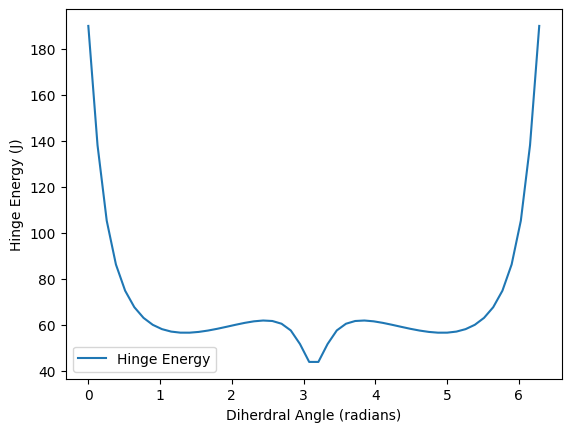

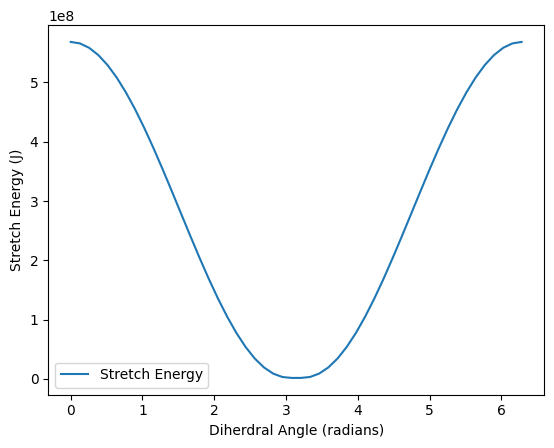

In [12]:

plt.plot(thetas, he, label='Hinge Energy')
plt.ylabel('Hinge Energy (J)')
plt.xlabel('Diherdral Angle (radians)')
plt.legend()
plt.show()


plt.plot(thetas, se, label='Stretch Energy')
plt.ylabel('Stretch Energy (J)')
plt.xlabel('Diherdral Angle (radians)')
plt.legend()
plt.show()


# Save data. 03-23-25
#data = np.column_stack((thetas, he))  # create a ~ by 2 array
#np.savetxt('theta_HingeE.dat', data, fmt='%16.10f')


In [13]:
options = dismech.AnimationOptions(
    z_lim=(-1.0, 1.0), x_lim=(0, 1.0), y_lim=(0, 1.0), 
    title='all thetas')
fig = dismech.get_interactive_animation_plotly(base_robot, thetas, qs, options)
fig.show()
#fig.show(renderer='browser')


print("fixed camera angle:\n")

options = dismech.AnimationOptions(
    z_lim=(-1.0, 1.0), 
    x_lim=(0, 1.0), 
    y_lim=(0, 1.0), 
    title='all thetas'
)
fig = dismech.get_interactive_animation_plotly(base_robot, thetas, qs, options)

# fix aspect ratio and set camera angle.
fig.update_layout(
    scene=dict(
        aspectmode='cube',
        camera=dict(
            eye=dict(x=-0.6, y=2.0, z=1.0)
        )
    )
)

# Enforce the same camera settings for every frame.
if fig.frames is not None:
    for frame in fig.frames:
        frame.layout = dict(
            scene=dict(
                camera=dict(
                    eye=dict(x=-0.6, y=2.0, z=1.0)  
                )
            )
        )

#fig.show(renderer='browser')



fixed camera angle:

